# Introduction

The effect of social media on politics is a frequently discussed issue. Claims are often made by media outlets and regulators that social media has a generally negative effect on political sentiment in the US—that social media creates “echo chambers” of like-minded people which lead to polarization and increasingly extreme views.

Using Presidential approval ratings as the target variable, I will attempt to demonstrate whether this phenomenon is based in reality using comments from Reddit.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

from functions import all_models as m

import warnings
warnings.filterwarnings("ignore")

In [2]:
reddit = pd.read_csv('Data/reddit_data.csv', index_col=0)

In [3]:
reddit.head()

,author,body,created_utc,permalink,score,subreddit,total_awards_received,editable,Polarity,Subjectivity,Sentiment,date,target
0,execdysfunction,Maybe. We need to be aiming higher,2021-04-03 19:41:59,/r/politics/comments/mj839d/schumer_senate_wil...,1,politics,0,NaN,0.250000,0.500000,Positive,4/3/2021,53.414394
1,yappledapple,I hadn't heard that one. I think the ones stil...,2021-04-03 19:41:59,/r/politics/comments/mjcrfb/schumer_says_senat...,1,politics,0,NaN,-0.166667,0.500000,Negative,4/3/2021,53.414394
2,Tots4trump,“The statue was presented to the British as a ...,2021-04-03 19:41:56,/r/politics/comments/mjczhl/confederate_symbol...,1,politics,0,NaN,0.295000,0.430000,Positive,4/3/2021,53.414394
3,DroopyMcCool,Is this something that is in the DOI's purview...,2021-04-03 19:41:55,/r/politics/comments/mj6klw/secretary_deb_haal...,1,politics,0,NaN,0.068182,0.227273,Positive,4/3/2021,53.414394
4,FlyingRock,New York legalizing is definitely why it's bei...,2021-04-03 19:41:55,/r/politics/comments/mj839d/schumer_senate_wil...,1,politics,0,NaN,0.033939,0.517576,Positive,4/3/2021,53.414394


In [4]:
reddit.drop(columns=['author', 'permalink', 'created_utc', 'Sentiment', 
                     'date', 'editable', 'total_awards_received'], inplace=True)

In [5]:
stop_words = stopwords.words('english')

def process(text):
    """Process text data by removing stopwords, tokenizing, and lemmatizing a document"""
    lemmatizer = WordNetLemmatizer()
    tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
    
    text = text.lower() #convert to lowercase
    text = tokenizer.tokenize(text) #tokenize
    text = [word for word in text if word not in stop_words] #remove stopwords
    text = [lemmatizer.lemmatize(word) for word in text] #lemmatize
    text = ' '.join(text) #convert list of words back to a string
    return text

In [8]:
x = reddit.drop(columns=['target'])
y = reddit['target']

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=16)

In [9]:
#apply pre-processing to comments
x_train_text = x_train['body'].apply(process)
x_test_text = x_test['body'].apply(process)

In [10]:
#vectorize comments
vectorizer = TfidfVectorizer(stop_words=stop_words, token_pattern='[a-zA-Z0-9]+', max_features=1000)
x_train_text = vectorizer.fit_transform(x_train_text)
x_test_text = vectorizer.transform(x_test_text)

In [12]:
#combine vectorized text with remaining data
x_train_text_df = pd.DataFrame(x_train_text.todense(), columns = vectorizer.get_feature_names()) #put word vectors in DataFrame
x_train.drop(columns=['body'], inplace=True) #drop unprocessed comments from Dataframe
x_train = pd.get_dummies(x_train) #convert categorical data to numerical columns
x_train_text_df.set_index(x_train.index, inplace=True) #match word vectors with original index
x_train = pd.concat([x_train, x_train_text_df], axis=1).reindex(x_train.index) #combine dataframes

x_test_text_df = pd.DataFrame(x_test_text.todense(), columns = vectorizer.get_feature_names())
x_test.drop(columns=['body'], inplace=True)
x_test = pd.get_dummies(x_test)
x_test_text_df.set_index(x_test.index, inplace=True)
x_test = pd.concat([x_test, x_test_text_df], axis=1).reindex(x_test.index)

In [13]:
objects = [LinearRegression(), 
           Pipeline([('ss', StandardScaler(with_mean=False)), ('knn', KNeighborsRegressor())]),
           DecisionTreeRegressor(), 
           XGBRegressor(),
           CatBoostRegressor(verbose=False),
          lgb.LGBMRegressor()]
index = ['Linear Regression', 'Nearest Neighbors', 'Decision Tree', 'XGBoost', 'CatBoost', 'LightGBM']

## Initial Models

In [14]:
models = m(x_train, x_test, y_train, y_test, objects=objects, index=index)

Linear Regression model fit...
Nearest Neighbors model fit...
Decision Tree model fit...
XGBoost model fit...
CatBoost model fit...
LightGBM model fit...


,RMSE,R-Squared
Linear Regression,2.141777,0.035141
Nearest Neighbors,2.325746,-0.137732
Decision Tree,2.824817,-0.678402
XGBoost,2.101426,0.071155
CatBoost,2.094685,0.077104
LightGBM,2.095404,0.076470


Initial modelling results indicate that there is basically no correlation between our text and the target variable. Although the RMSE is only about 2 points, the range of possible target variables is only about 10 points.

In [23]:
def importances(model, vectorizer, title='Feature Importances'):
    importances = sorted(list(zip(model.feature_importances_, vectorizer.get_feature_names())))[-20:]
    plot = pd.DataFrame(importances, columns=['Importance', 'Feature'])

    fig, ax = plt.subplots(figsize=(15, 8))
    sns.barplot(data=plot, x='Importance', y='Feature')
    ax.set_title(title)
    ax.set_xlabel('Importance')
    ax.set_ylabel('Feature')
    plt.show();

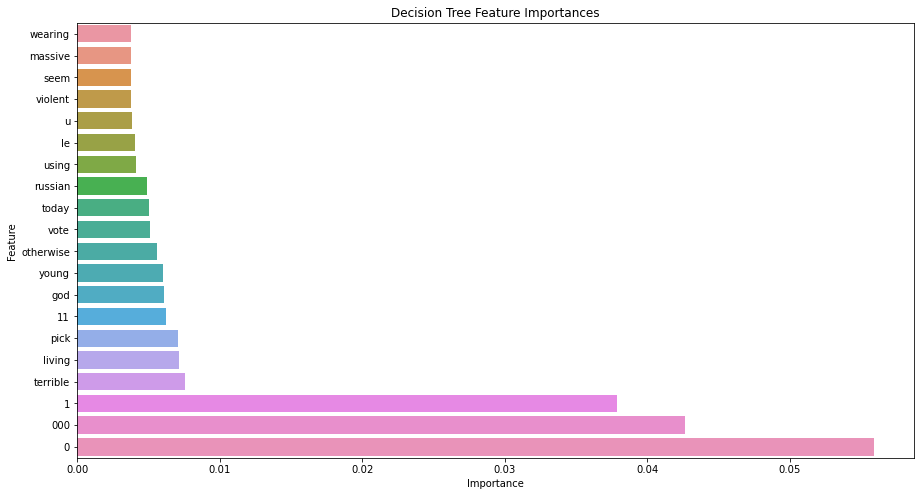

In [24]:
importances(models[2], vectorizer, title = 'Decision Tree Feature Importances')

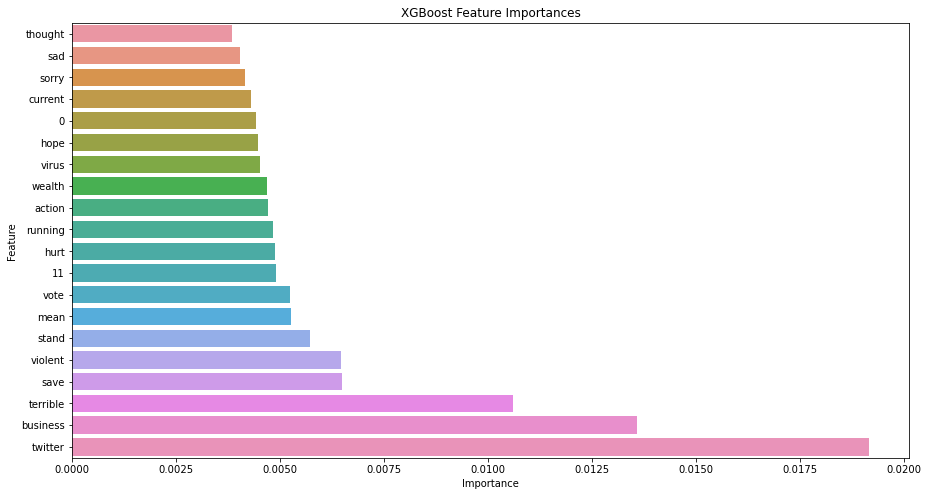

In [25]:
importances(models[3], vectorizer, title = 'XGBoost Feature Importances')

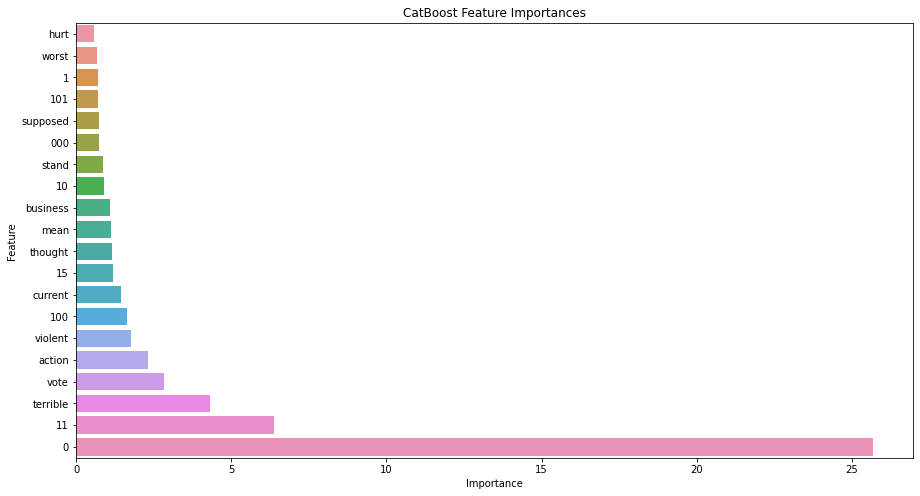

In [26]:
importances(models[4], vectorizer, title = 'CatBoost Feature Importances')

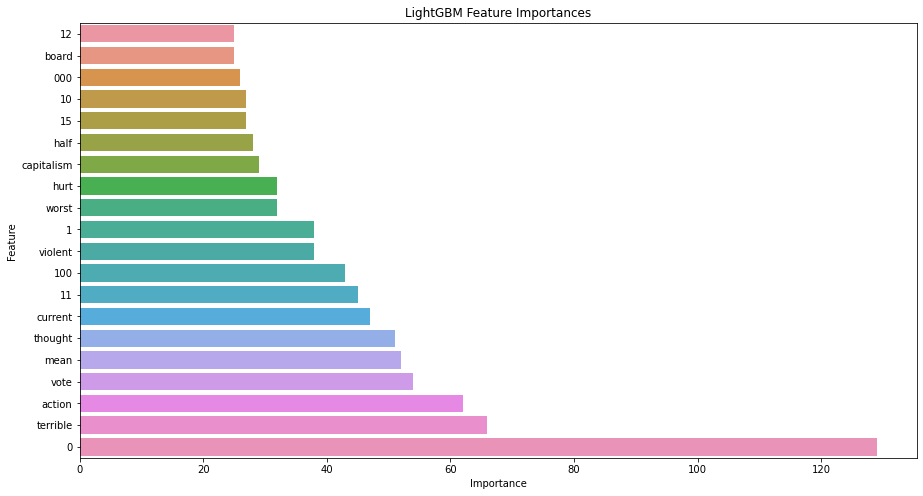

In [27]:
importances(models[5], vectorizer, title = 'LightGBM Feature Importances')

Looking at the feature importances for each model, there is very little in common amongst the different models, and there are few words that seem to have much relevence with the political climate of 2021. 

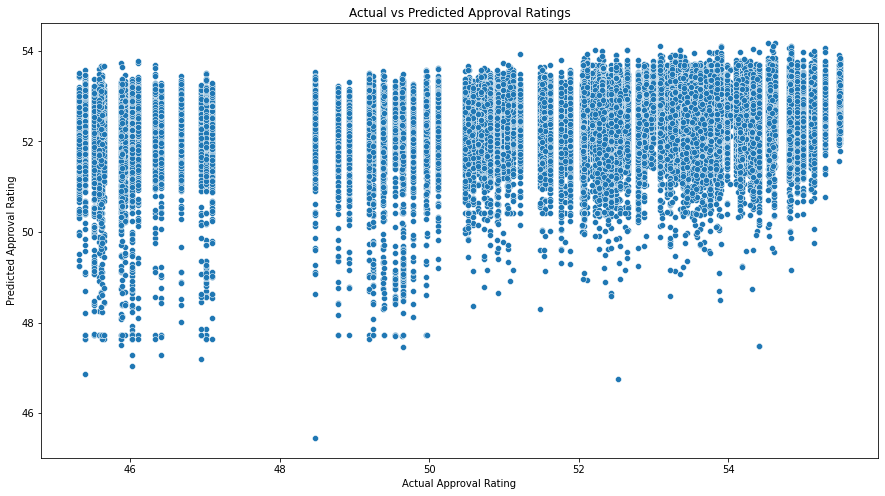

In [28]:
prediction = models[4].predict(x_test)

fig, ax = plt.subplots(figsize=(15, 8))
sns.scatterplot(x=y_test, y=prediction)
ax.set_xlabel('Actual Approval Rating')
ax.set_ylabel('Predicted Approval Rating')
ax.set_title('Actual vs Predicted Approval Ratings');

Plotting the actual approval rating vs the predicted approval rating from the "best performing" model clearly shows how little Reddit comments indicate Presidential approval rating. 

## PCA

In [29]:
pca = PCA(n_components=20)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

In [30]:
pca_model = CatBoostRegressor(verbose=False)
pca_model.fit(x_train_pca, y_train)

In [31]:
prediction = pca_model.predict(x_test_pca)
rmse = mean_squared_error(y_test, prediction, squared=False)
rsquared = r2_score(y_test, prediction)

print(f'R-Squared: {rsquared} \nRMSE: {rmse}')

R-Squared: 0.041609776065982484 
RMSE: 2.134585353762938


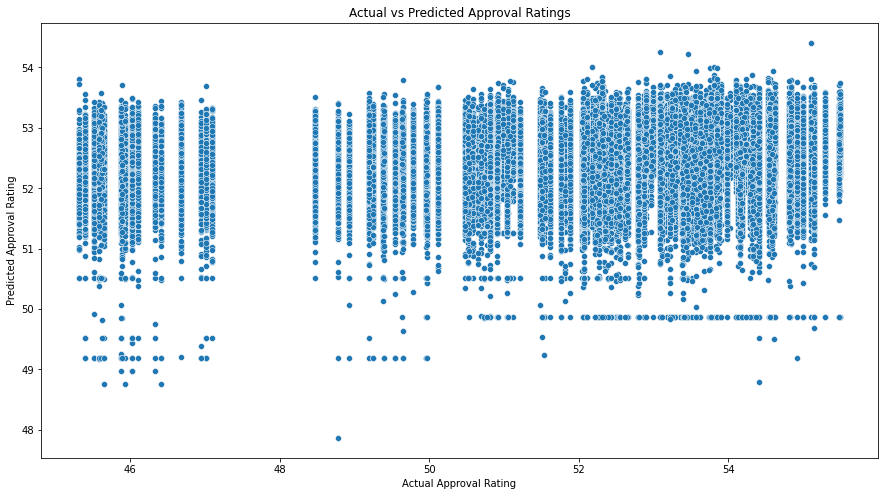

In [33]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.scatterplot(x=y_test, y=prediction)
ax.set_xlabel('Actual Approval Rating')
ax.set_ylabel('Predicted Approval Rating')
ax.set_title('Actual vs Predicted Approval Ratings');

## Clustering

In [34]:
cluster = KMeans()
x_train_cluster = cluster.fit_transform(x_train)
x_test_cluster = cluster.transform(x_test)

In [35]:
cluster_model = CatBoostRegressor(verbose=False)
cluster_model.fit(x_train_cluster, y_train)

In [36]:
prediction = cluster_model.predict(x_test_pca)
rmse = mean_squared_error(y_test, prediction, squared=False)
rsquared = r2_score(y_test, prediction)

print(f'R-Squared: {rsquared} \nRMSE: {rmse}')

R-Squared: -0.12268595770246926 
RMSE: 2.310316517148458


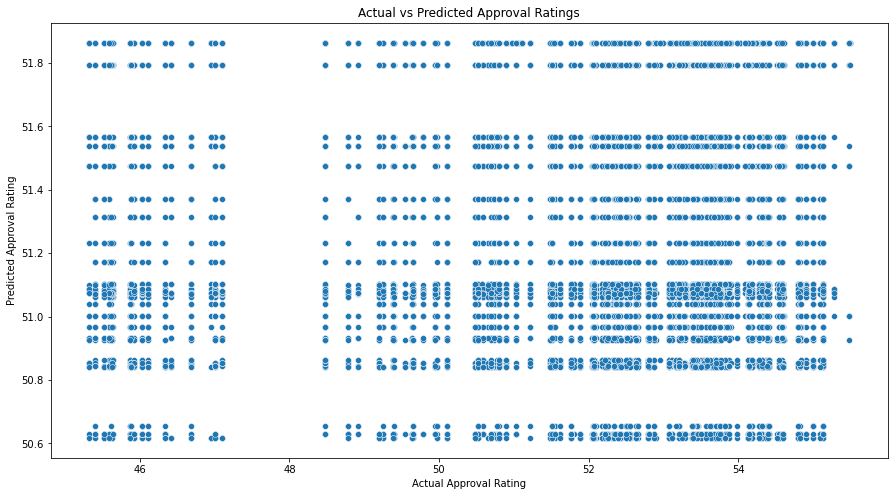

In [37]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.scatterplot(x=y_test, y=prediction)
ax.set_xlabel('Actual Approval Rating')
ax.set_ylabel('Predicted Approval Rating')
ax.set_title('Actual vs Predicted Approval Ratings');

Neither PCA nor clustering provide any measureable improvement in modelling. 

# Model by Viewpoint -- Left

Finally, I will try modelling using only left-leaning or right-leaning subreddits to see if one side or the other provides any improvement in our modelling.

In [38]:
left = reddit.loc[reddit['subreddit'] == 'democrats']
right = reddit.loc[reddit['subreddit'] == 'Conservative']

In [39]:
x = left.drop(columns=['target'])
y = left['target']

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=16)

In [40]:
x_train_text = x_train['body'].apply(process)
x_test_text = x_test['body'].apply(process)

In [41]:
vectorizer = TfidfVectorizer(stop_words=stop_words, token_pattern='[a-zA-Z0-9]+', max_features=1000)
x_train_text = vectorizer.fit_transform(x_train_text)
x_test_text = vectorizer.transform(x_test_text)

In [42]:
x_train_text_df = pd.DataFrame(x_train_text.todense(), columns = vectorizer.get_feature_names())
x_test_text_df = pd.DataFrame(x_test_text.todense(), columns = vectorizer.get_feature_names())

In [43]:
x_train.drop(columns=['body'], inplace=True)
x_train = pd.get_dummies(x_train)
x_train_text_df.set_index(x_train.index, inplace=True)
x_train = pd.concat([x_train, x_train_text_df], axis=1).reindex(x_train.index)

x_test.drop(columns=['body'], inplace=True)
x_test = pd.get_dummies(x_test)
x_test_text_df.set_index(x_test.index, inplace=True)
x_test = pd.concat([x_test, x_test_text_df], axis=1).reindex(x_test.index)

In [44]:
left_model = CatBoostRegressor(verbose=False)
left_model.fit(x_train, y_train)

In [45]:
prediction = left_model.predict(x_test)
rmse = mean_squared_error(y_test, prediction, squared=False)
rsquared = r2_score(y_test, prediction)

print(f'R-Squared: {rsquared} \nRMSE: {rmse}')

R-Squared: 0.11006504269631345 
RMSE: 2.3637259671177624


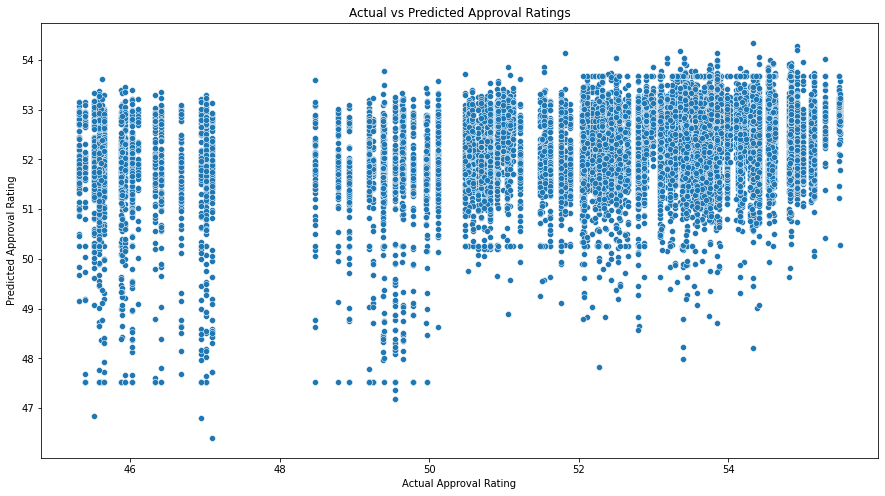

In [46]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.scatterplot(x=y_test, y=prediction)
ax.set_xlabel('Actual Approval Rating')
ax.set_ylabel('Predicted Approval Rating')
ax.set_title('Actual vs Predicted Approval Ratings');

# Model by Viewpoint - Right

In [47]:
x = right.drop(columns=['target'])
y = right['target']

In [48]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=16)

In [49]:
x_train_text = x_train['body'].apply(process)
x_test_text = x_test['body'].apply(process)

In [50]:
vectorizer = TfidfVectorizer(stop_words=stop_words, token_pattern='[a-zA-Z0-9]+', max_features=1000)
x_train_text = vectorizer.fit_transform(x_train_text)
x_test_text = vectorizer.transform(x_test_text)

In [51]:
x_train_text_df = pd.DataFrame(x_train_text.todense(), columns = vectorizer.get_feature_names())
x_test_text_df = pd.DataFrame(x_test_text.todense(), columns = vectorizer.get_feature_names())

In [52]:
x_train.drop(columns=['body'], inplace=True)
x_train = pd.get_dummies(x_train)
x_train_text_df.set_index(x_train.index, inplace=True)
x_train = pd.concat([x_train, x_train_text_df], axis=1).reindex(x_train.index)

x_test.drop(columns=['body'], inplace=True)
x_test = pd.get_dummies(x_test)
x_test_text_df.set_index(x_test.index, inplace=True)
x_test = pd.concat([x_test, x_test_text_df], axis=1).reindex(x_test.index)

In [54]:
right_model = CatBoostRegressor(verbose=False)
right_model.fit(x_train, y_train)

In [55]:
prediction = right_model.predict(x_test)
rmse = mean_squared_error(y_test, prediction, squared=False)
rsquared = r2_score(y_test, prediction)

print(f'R-Squared: {rsquared} \nRMSE: {rmse}')

R-Squared: 0.05252913868876796 
RMSE: 2.005764953387742


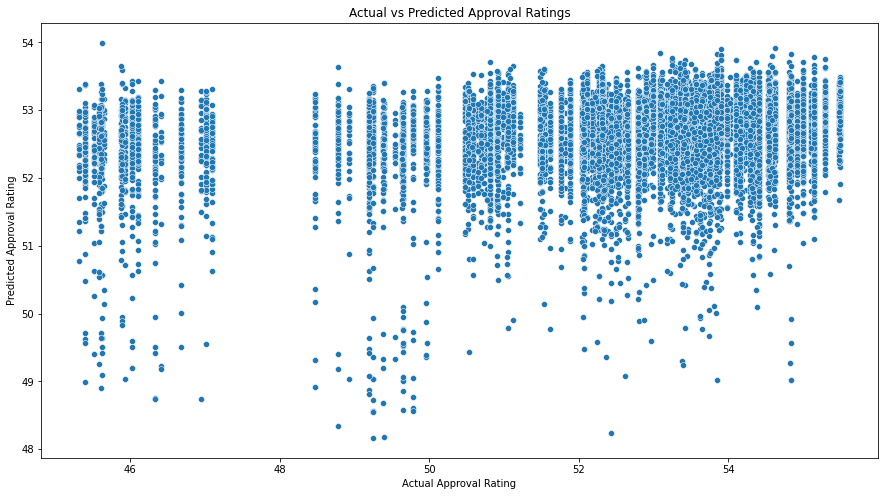

In [56]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.scatterplot(x=y_test, y=prediction)
ax.set_xlabel('Actual Approval Rating')
ax.set_ylabel('Predicted Approval Rating')
ax.set_title('Actual vs Predicted Approval Ratings');

## Conclusion

Based on these models, we cannot reject the hypothesis that social media echo-chambers exist. It is clear that, at least on Reddit, there is essentially no correlation between sentiment on political subreddits and Presidential approval ratings, which provide a more objective assessment of political sentiment in the US.